# Stack Overflow Tags Prediction with Recurrent Neural Networks

These codes were referrd from [this GitHub repository](https://github.com/theRajeshReddy/StackOverFlow-Classification).

This taks to predict tags for a StackOverflow dataset.
Given Questions and Body, we need to predict the tags for each Questions presented.

This notebook is run on Google Colaboratory.


### Import the necessary libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import collections

### Get the data

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!unzip "../content/drive/My Drive/Colab Notebooks/StackOverflow/new_train_2.zip" -d train

Archive:  ../content/drive/My Drive/Colab Notebooks/StackOverflow/new_train_2.zip
  inflating: train/new_train_2.csv   


In [0]:
#read the data
df_tags = pd.read_csv("../content/train/new_train_2.csv")

## Plot the Top 20 tags 

Identify the tags by count

In [0]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 1,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('android', 10036), ('php', 6171), ('jquery', 5574), ('javascript jquery', 4936), ('javascript', 4908), ('java', 4782), ('c#', 4602), ('python', 3286), ('c++', 3204), ('php mysql', 3117), ('mysql', 3100), ('html css', 2662), ('iphone', 2471), ('asp.net', 2376), ('c# asp.net', 2055), ('ruby-on-rails', 1956), ('java android', 1734), ('css', 1697), ('c', 1659), ('iphone objective-c', 1200)]


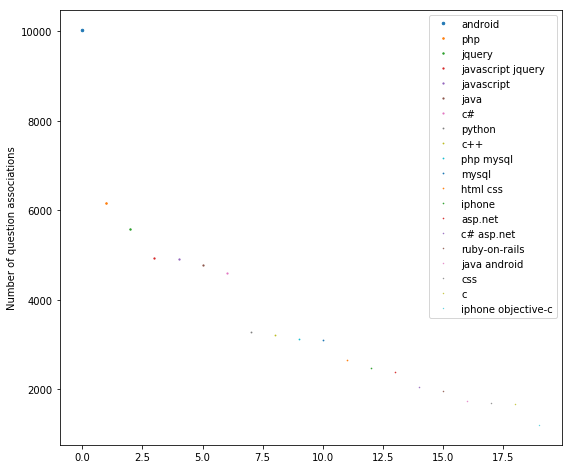

In [63]:
tagCount =  collections.Counter(list(df_tags['Tags'])).most_common(20)
print(tagCount)
plot_tags(tagCount)

In [0]:
top20=['android', 'php', 'jquery', 'javascript jquery', 'javascript',
       'java', 'c#', 'python','c++', 'php mysql', 
       'mysql', 'html css', 'iphone', 'asp.net', 'c# asp.net', 
       'ruby-on-rails','java android','css', 'c', 'iphone objective-c']

In [10]:
tag_top20= df_tags[df_tags.Tags.isin(top20)]
print (tag_top20.shape)
tag_top20.head()

(71526, 5)


,Unnamed: 0,Id,Title,Body,Tags
16,1774935,1774936,C++. Could anyone help me find error in my cod...,<p><br />\nI am trying to solve the next equat...,c++
41,1590888,1590889,Use LIKE and NOT LIKE more efficeinty when tes...,<p>I have the following query:</p>\n\n<pre><co...,mysql
48,717332,717333,network programming in python,<p>how do i run a python program that is recei...,python
60,2056847,2056848,Error Sending Dynamic values to the mysql data...,<p>I am trying to make a attendence form but t...,mysql
63,3987407,3987408,jQuery: something is wrong with how this loop ...,<pre><code>function appendRefToLinks(ref){\n ...,jquery


In [0]:
tag_top20 = tag_top20.drop(columns=['Unnamed: 0'])

In [0]:
def add_tags(question_id):
    return tag_top20[tag_top20['Id'] == question_id['Id']].Tags.values

top20 = tag_top20.apply(add_tags, axis=1)

In [13]:
len(top20),tag_top20.shape

(20, (71526, 4))

In [0]:
top20_tags=tag_top20.loc[tag_top20.astype(str).drop_duplicates().index]

## Model training using LSTM and GRU

**Recurrent Neural Networks (RNN)** take their input not just the current input example as they see, but also what they have perceived previously in time. All the inputs are related to each other. 

![RNN](https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png)

First, it takes the X(0) from the sequence of input and then it outputs h(0) which together with X(1) is the input for the next step. So, the h(0) and X(1) is the input for the next step. Similarly, h(1) from the next is the input with X(2) for the next step and so on. This way, it keeps remembering the context while training.

RNN has advantages that they can model sequence of data so that each sample can be assumed to be dependednt on previous one, but they have several disadavantages in vanishing gradient, and cannot process very long sequences if using `tanh` or `relu` as activation function.

**Gated Recurrent Unit (GRU)** aims to solve the vanishing gradient problem which comes with a standard recurrent neural netwrork. To solve the vanishing gradient problem of a standard RNN, GRU uses, so called, update gate and reset gate. The update gate helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. Reset gate is used from the model to decide how much of the past information to forget.

**Long Short Term Memory (LSTM)** network comprises of different memory blocks called cells. There are two states that are being transferred to the next cell; the cell state and the hidden state. The memory blocks are responsible for remembering things and manipulations to this memory is done through three major mechanisms, called gates. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation.

![LSTM and GRU](https://miro.medium.com/max/1516/1*yBXV9o5q7L_CvY7quJt3WQ.png)


References:

1. [Understanding RNN and LSTM](https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e)

2. [Illustrated Guide to LSTMs and GRUs](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

3. [Introduction to LSTM](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
from keras.models import Model, Sequential

Using TensorFlow backend.


**Labelling the data**

In [16]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(top20_tags.Tags)
labels = multilabel_binarizer.classes_
labels

array([' ', '#', '+', '-', '.', 'a', 'b', 'c', 'd', 'e', 'h', 'i', 'j',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y'],
      dtype=object)

**Split the data into train and test set**

In [0]:
train,test=train_test_split(top20_tags,test_size=0.2,random_state=24)

In [18]:
train.shape,test.shape

((57220, 4), (14306, 4))

In [0]:
X_train_t=train['Title']
X_train_b=train['Body']
y_train=multilabel_binarizer.transform(train['Tags'])
X_test_t=test['Title']
X_test_b=test['Body']
y_test=multilabel_binarizer.transform(test['Tags'])

In [20]:
import nltk
nltk.download('punkt')

sent_lens_t=[]
for sent in train['Title']:
    sent_lens_t.append(len(word_tokenize(sent)))
max(sent_lens_t)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


43

In [21]:
np.quantile(sent_lens_t,0.97)

18.0

In [0]:
max_len_t = 18
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_t)
sequences_train_t = tok.texts_to_sequences(X_train_t)

In [23]:
vocab_len_t=len(tok.index_word.keys())
vocab_len_t

16622

In [24]:
sequences_matrix_train_t = sequence.pad_sequences(sequences_train_t,maxlen=max_len_t)
sequences_matrix_train_t

array([[   0,    0,    0, ...,    5,   35,  125],
       [   0,    0,    0, ...,   35,   44, 2929],
       [   0,    0,    0, ...,   47,  336, 4412],
       ...,
       [   0,    0,    0, ...,   17,   42,  211],
       [   0,    0,    0, ...,    7, 1479, 1890],
       [   0,    0,    0, ...,  572,    8,   19]], dtype=int32)

In [0]:
sequences_test_t = tok.texts_to_sequences(X_test_t)
sequences_matrix_test_t = sequence.pad_sequences(sequences_test_t,maxlen=max_len_t)

In [26]:
sequences_matrix_train_t.shape,sequences_matrix_test_t.shape,y_train.shape,y_test.shape

((57220, 18), (14306, 18), (57220, 25), (14306, 25))

In [27]:
sent_lens_b=[]
for sent in train['Body']:
    sent_lens_b.append(len(word_tokenize(sent)))
max(sent_lens_b)

10962

In [28]:
np.quantile(sent_lens_b,0.90)

480.0

In [0]:
max_len_b = 600
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_b)
sequences_train_b = tok.texts_to_sequences(X_train_b)

In [30]:
vocab_len_b =len(tok.index_word.keys())
vocab_len_b

185998

In [31]:
sequences_matrix_train_b = sequence.pad_sequences(sequences_train_b,maxlen=max_len_b)
sequences_matrix_train_b

array([[ 244,  558,  116, ...,  141,    5,    9],
       [   0,    0,    0, ...,    5,  192,    1],
       [   0,    0,    0, ...,  608,   39,    1],
       ...,
       [   0,    0,    0, ...,    3,    5,    9],
       [   0,    0,    0, ...,  445,    5,    9],
       [   0,    0,    0, ...,    2, 2069,    1]], dtype=int32)

In [0]:
sequences_test_b = tok.texts_to_sequences(X_test_b)
sequences_matrix_test_b = sequence.pad_sequences(sequences_test_b,maxlen=max_len_b)

In [33]:
sequences_matrix_train_t.shape,sequences_matrix_train_b.shape,y_train.shape

((57220, 18), (57220, 600), (57220, 25))

In [34]:
sequences_matrix_test_t.shape,sequences_matrix_test_b.shape,y_test.shape

((14306, 18), (14306, 600), (14306, 25))

## Training with LSTM model

In [0]:
def LSTM_model():
    # Title Only
    title_input = Input(name='title_input',shape=[max_len_t])
    title_Embed = Embedding(vocab_len_t+1,2000,input_length=max_len_t,mask_zero=True,name='title_Embed')(title_input)
    lstm_out_t = LSTM(300)(title_Embed)
    # auxiliary output to tune LSTM weights smoothly 
    auxiliary_output = Dense(25, activation='sigmoid', name='aux_output')(lstm_out_t)   
    
    # Body Only
    body_input = Input(name='body_input',shape=[max_len_b]) 
    body_Embed = Embedding(vocab_len_b+1,170,input_length=max_len_b,mask_zero=True,name='body_Embed')(body_input)
    lstm_out_b = LSTM(200)(body_Embed)
    
    # combined with LSTM output
    com = concatenate([lstm_out_t, lstm_out_b])
    
    # now the combined data is being fed to dense layers
    dense1 = Dense(400,activation='relu')(com)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150,activation='relu')(bn)
    
    main_output = Dense(25, activation='sigmoid', name='main_output')(dense2)
    
    model = Model(inputs=[title_input, body_input],outputs=[main_output, auxiliary_output])
    return model

In [36]:
model = LSTM_model()
model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 18)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 600)          0                                            
__________________________________________________________________________________________________
title_Embed (Embedding)         (None, 18, 2000)     33246000    title_input[0][0]                
_____________________________________________________________________________

**Install the RAdam**

A new optimizer based on [this paper](https://arxiv.org/pdf/1908.03265.pdf) The Rectified Adam is proved to be more effective than Adam and Vanilla Adam. 

In [37]:
!pip install keras-rectified-adam
from keras_radam import RAdam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=04fdf057a0d98824014511a027c67d0da0b6636f90f2a2443355a282b54816e4
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


**Training the data**

In [38]:
optimizer=RAdam(min_lr=1e-5)

model.compile(optimizer,loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [39]:
results=model.fit({'title_input': sequences_matrix_train_t, 'body_input': sequences_matrix_train_b},
          {'main_output': y_train, 'aux_output': y_train},
          validation_data=[{'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},
          {'main_output': y_test, 'aux_output': y_test}],
          epochs=10, batch_size=800)




Train on 57220 samples, validate on 14306 samples
Epoch 1/10





57220/57220 [==============================] - 225s 4ms/step - loss: 38.6451 - main_output_loss: 18.9699 - aux_output_loss: 19.6753 - main_output_acc: 0.0867 - aux_output_acc: 0.0503 - val_loss: 36.4084 - val_main_output_loss: 16.9131 - val_aux_output_loss: 19.4953 - val_main_output_acc: 0.1148 - val_aux_output_acc: 0.1218
Epoch 2/10
57220/57220 [==============================] - 218s 4ms/step - loss: 34.9324 - main_output_loss: 16.2236 - aux_output_loss: 18.7088 - main_output_acc: 0.0940 - aux_output_acc: 0.1856 - val_loss: 32.9846 - val_main_output_loss: 15.5566 - val_aux_output_loss: 17.4281 - val_main_output_acc: 0.1674 - val_aux_output_acc: 0.2377
Epoch 3/10
57220/57220 [==============================] - 216s 4ms/step - loss: 31.5676 - main_output_loss: 15.0140 - aux_output_loss: 16.5536 - main_output_acc: 0.1746 - aux_output_acc: 0.2358 - val_loss: 30.7189 - val_main_output_loss: 14.7265 - val_aux_output_loss: 1

### Results trained with LSTM model

In [40]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

14306/14306 [==============================] - 276s 19ms/step


In [41]:
from sklearn.metrics import classification_report,f1_score
print(f1_score(y_test,predicted_main>.55,average='samples'))

0.7819872455658101


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [42]:
print(classification_report(y_test,predicted_main>.55))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51      3178
           1       0.65      0.51      0.57      1355
           2       0.66      0.51      0.58       618
           3       0.82      0.59      0.68       623
           4       0.82      0.70      0.76       901
           5       0.91      0.80      0.85      6601
           6       0.81      0.59      0.68       623
           7       0.84      0.72      0.78      5362
           8       0.93      0.91      0.92      2385
           9       0.87      0.81      0.84      3675
          10       0.80      0.86      0.83      3791
          11       0.90      0.81      0.85      5418
          12       0.91      0.77      0.83      4593
          13       0.78      0.82      0.80      2187
          14       0.76      0.80      0.78      1807
          15       0.91      0.89      0.90      5060
          16       0.92      0.91      0.91      4159
          17       0.85    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [43]:
test.iloc[24]

Id                                                 2586970
Title                                    Android: UnitTest
Body     <p>Need some advice. I have an App. And I need...
Tags                                               android
Name: 54121, dtype: object

In [44]:
predicted_main[24].round(decimals = 2)

array([0.04, 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
       1.  , 0.05, 0.  , 0.  , 1.  , 1.  , 0.  , 0.  , 1.  , 0.  , 0.  ,
       0.  , 0.05, 0.  ], dtype=float32)

In [45]:
labels

array([' ', '#', '+', '-', '.', 'a', 'b', 'c', 'd', 'e', 'h', 'i', 'j',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y'],
      dtype=object)

In [0]:
model.save('./stackoverflow_tags_lstm.h5')

## Training with GRU Model

In [0]:
def GRU_model():
    # Title Only
    title_input = Input(name='title_input',shape=[max_len_t])
    title_Embed = Embedding(vocab_len_t+1,2000,input_length=max_len_t,mask_zero=True,name='title_Embed')(title_input)
    gru_out_t = GRU(300)(title_Embed)
    # auxiliary output to tune GRU weights smoothly 
    auxiliary_output = Dense(25, activation='sigmoid', name='aux_output')(gru_out_t)   
    
    # Body Only
    body_input = Input(name='body_input',shape=[max_len_b]) 
    body_Embed = Embedding(vocab_len_b+1,170,input_length=max_len_b,mask_zero=True,name='body_Embed')(body_input)
    gru_out_b = GRU(200)(body_Embed)
    
    # combined with GRU output
    com = concatenate([gru_out_t, gru_out_b])
    
    # now the combined data is being fed to dense layers
    dense1 = Dense(400,activation='relu')(com)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150,activation='relu')(bn)
    
    main_output = Dense(25, activation='sigmoid', name='main_output')(dense2)
    
    model = Model(inputs=[title_input, body_input],outputs=[main_output, auxiliary_output])
    return model

In [48]:
model = GRU_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 18)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 600)          0                                            
__________________________________________________________________________________________________
title_Embed (Embedding)         (None, 18, 2000)     33246000    title_input[0][0]                
__________________________________________________________________________________________________
body_Embed (Embedding)          (None, 600, 170)     31619830    body_input[0][0]                 
____________________________________________________________________________________________

In [0]:
ptimizer=RAdam(min_lr=1e-5)

model.compile(optimizer,loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [50]:
results=model.fit({'title_input': sequences_matrix_train_t, 'body_input': sequences_matrix_train_b},
          {'main_output': y_train, 'aux_output': y_train},
          validation_data=[{'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},
          {'main_output': y_test, 'aux_output': y_test}],
          epochs=10, batch_size=800)

Train on 57220 samples, validate on 14306 samples
Epoch 1/10
57220/57220 [==============================] - 170s 3ms/step - loss: 32.4817 - main_output_loss: 15.9856 - aux_output_loss: 16.4961 - main_output_acc: 0.1372 - aux_output_acc: 0.2126 - val_loss: 30.0264 - val_main_output_loss: 14.9297 - val_aux_output_loss: 15.0967 - val_main_output_acc: 0.1677 - val_aux_output_acc: 0.2557
Epoch 2/10
57220/57220 [==============================] - 167s 3ms/step - loss: 29.0149 - main_output_loss: 14.4208 - aux_output_loss: 14.5941 - main_output_acc: 0.1898 - aux_output_acc: 0.2333 - val_loss: 29.3455 - val_main_output_loss: 14.5078 - val_aux_output_loss: 14.8377 - val_main_output_acc: 0.2084 - val_aux_output_acc: 0.1872
Epoch 3/10
57220/57220 [==============================] - 167s 3ms/step - loss: 27.8689 - main_output_loss: 13.7630 - aux_output_loss: 14.1059 - main_output_acc: 0.2014 - aux_output_acc: 0.1994 - val_loss: 29.2570 - val_main_output_loss: 14.3538 - val_aux_output_loss: 14.9032 -

In [51]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

14306/14306 [==============================] - 242s 17ms/step


In [0]:
from sklearn.metrics import classification_report,f1_score

In [53]:
print(f1_score(y_test,predicted_main>.55,average='samples'))

0.8006064500982707


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [54]:
print(classification_report(y_test,predicted_main>.55))

              precision    recall  f1-score   support

           0       0.54      0.48      0.51      3178
           1       0.67      0.58      0.62      1355
           2       0.64      0.66      0.65       618
           3       0.79      0.64      0.70       623
           4       0.81      0.73      0.77       901
           5       0.88      0.85      0.86      6601
           6       0.79      0.64      0.71       623
           7       0.81      0.80      0.80      5362
           8       0.94      0.92      0.93      2385
           9       0.88      0.81      0.85      3675
          10       0.86      0.79      0.83      3791
          11       0.86      0.85      0.86      5418
          12       0.89      0.81      0.85      4593
          13       0.85      0.75      0.80      2187
          14       0.84      0.73      0.78      1807
          15       0.93      0.89      0.91      5060
          16       0.93      0.90      0.92      4159
          17       0.84    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [55]:
test.iloc[24]

Id                                                 2586970
Title                                    Android: UnitTest
Body     <p>Need some advice. I have an App. And I need...
Tags                                               android
Name: 54121, dtype: object

In [56]:
labels

array([' ', '#', '+', '-', '.', 'a', 'b', 'c', 'd', 'e', 'h', 'i', 'j',
       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y'],
      dtype=object)

In [0]:
model.save('./stackoverflow_tags_GRU.h5')

## Summary

1. Only 20% of the data is used.
2. Data is trained by using Top 20 Tags data which has 71526 data.
3. Data is trained by using LSTM and GRU model.
4. The training is optimized by using the recent optimizer, Rectified Adam.
5. Results of the data

*LSTM model*:

Accuracy: 0.78

Micro-F1-score: 0.82

Macro-F1-score: 0.79

*GRU model*:

Accuracy: 0.80

Micro-F1-score: 0.83

Macro-F1-score: 0.80




  
  


